In [1]:
import json
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
file1_path = 'datasets/StreamingHistory_music_0.json'
file2_path = 'datasets/StreamingHistory_music_1.json'

def load_json_file(file_path):
    encodings = ['utf-8', 'utf-8-sig', 'latin-1', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return json.load(file)
        except UnicodeDecodeError:
            continue
    
    raise ValueError(f"Unable to decode the file {file_path} with any of the attempted encodings.")
    
def combine_music_data(file1_path, file2_path):
    # Load both JSON files
    data1 = load_json_file(file1_path)
    data2 = load_json_file(file2_path)
    
    # Combine the data
    combined_data = data1 + data2
    
    # Convert to DataFrame
    df = pd.DataFrame(combined_data)
    
    # Convert 'endTime' to datetime and 'msPlayed' to timedelta
    df['endTime'] = pd.to_datetime(df['endTime'])
    df['duration'] = pd.to_timedelta(df['msPlayed'], unit='ms')
    
    # Drop the 'msPlayed' column as we now have 'duration'
    df = df.drop('msPlayed', axis=1)
    
    # Convert 'duration' to HH:MM:SS format
    df['duration'] = df['duration'].apply(lambda x: f"{int(x.total_seconds() // 3600):02d}:{int(x.total_seconds() % 3600 // 60):02d}:{int(x.total_seconds() % 60):02d}")
    
    # Sort by endTime
    df = df.sort_values('endTime')
    
    # Reset index
    df = df.reset_index(drop=True)
    
    return df

In [3]:
result_df = combine_music_data(file1_path, file2_path)
result_df.to_csv('datasets/combined_music_data.csv', index=False, encoding='utf-8-sig')

# Analysis

In [4]:
df = pd.read_csv('datasets/combined_music_data.csv')

df.head()

,endTime,artistName,trackName,duration
0,2023-07-27 02:22:00,Tumm,Khong Con Ice,00:03:08
1,2023-07-30 02:58:00,Loresy,WOK,00:03:01
2,2023-07-30 02:59:00,HL8,Waist & Up,00:01:28
3,2023-07-30 03:02:00,Loresy,WOK,00:02:17
4,2023-07-30 03:13:00,Tumm,Khong Con Ice,00:09:04


# Time Spent Over Time

In [5]:
df['endTime'] = pd.to_datetime(df['endTime'])
df['duration'] = pd.to_timedelta(df['duration'])
# Calculate the total time spent on Spotify
total_time_spent = df['duration'].sum()

# Convert the total time spent to hours, minutes, and seconds
total_hours = int(total_time_spent.total_seconds() // 3600)
total_minutes = int((total_time_spent.total_seconds() % 3600) // 60)
total_seconds = int(total_time_spent.total_seconds() % 60)

# Print the total listening time
print(f"Total Listening Time on Spotify: {total_hours:02d}h:{total_minutes:02d}m:{total_seconds:02d}s")

Total Listening Time on Spotify: 421h:42m:19s


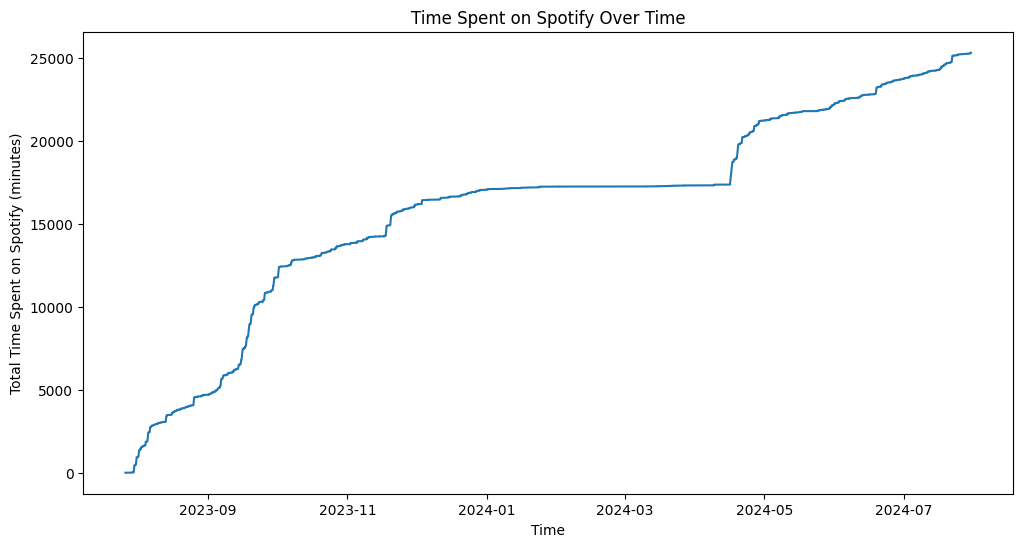

In [10]:
# Calculate the cumulative time spent on Spotify over time
df['time_spent'] = (df['duration'].dt.total_seconds() / 60).round(2)
df['time_spent_cumulative'] = df['time_spent'].cumsum()

# Plot the time spent on Spotify over time
plt.figure(figsize=(12, 6))
plt.plot(df['endTime'], df['time_spent_cumulative'])
plt.xlabel('Time')
plt.ylabel('Total Time Spent on Spotify (minutes)')
plt.title('Time Spent on Spotify Over Time')
plt.show()

# Track Counts Over Time

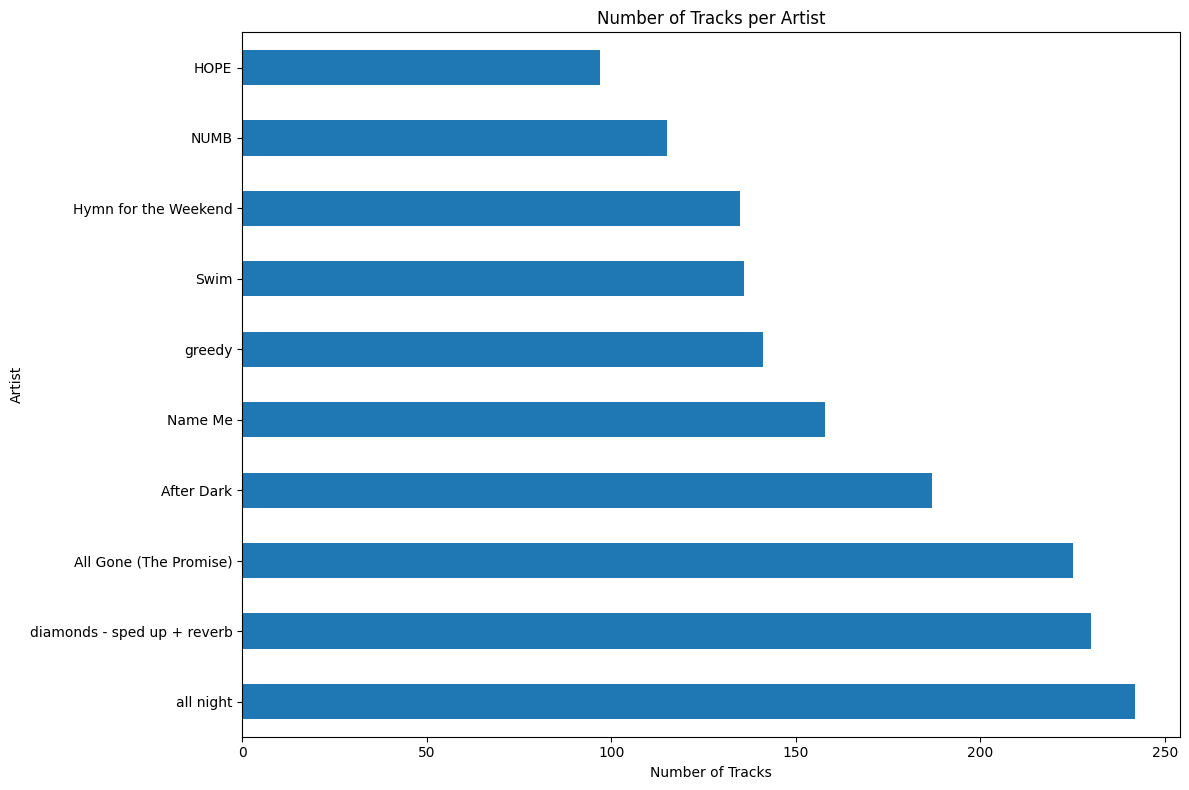

In [6]:
track_counts = df['trackName'].value_counts()

top_10_tracks = track_counts.head(10)
# Create a bar chart
plt.figure(figsize=(12, 8))
top_10_tracks.plot(kind='barh')
plt.title('Number of Tracks per Artist')
plt.xlabel('Number of Tracks')
plt.ylabel('Artist')
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
print(top_10_tracks)

trackName
all night                      242
diamonds - sped up + reverb    230
All Gone (The Promise)         225
After Dark                     187
Name Me                        158
greedy                         141
Swim                           136
Hymn for the Weekend           135
NUMB                           115
HOPE                            97
Name: count, dtype: int64


# Usage by Months

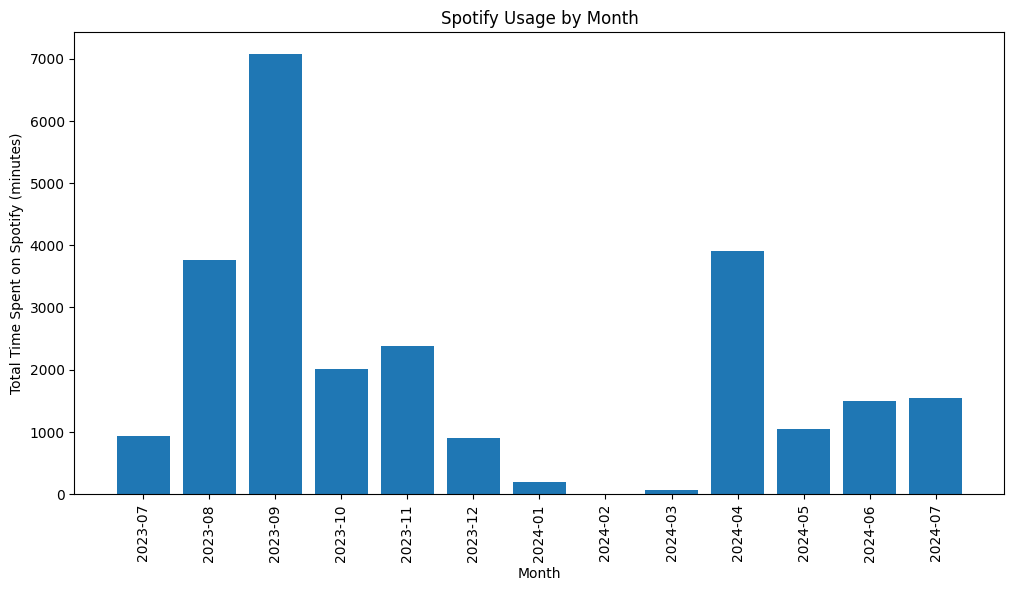

In [12]:
# Calculate the Spotify usage by month in minutes
usage_by_month = defaultdict(float)
for index, row in df.iterrows():
    month = row['endTime'].strftime('%Y-%m')
    usage_by_month[month] += row['duration'].total_seconds() / 60

# Sort the usage_by_month dictionary by month
sorted_usage = sorted(usage_by_month.items(), key=lambda x: x[0])

months, time_spent = zip(*sorted_usage)

# Plot the time spent on Spotify per month
plt.figure(figsize=(12, 6))
plt.bar(months, time_spent)
plt.xlabel('Month')
plt.ylabel('Total Time Spent on Spotify (minutes)')
plt.title('Spotify Usage by Month')
plt.xticks(rotation=90)
plt.show()

# Top Tracks Total Listening Time

<Figure size 1200x600 with 0 Axes>

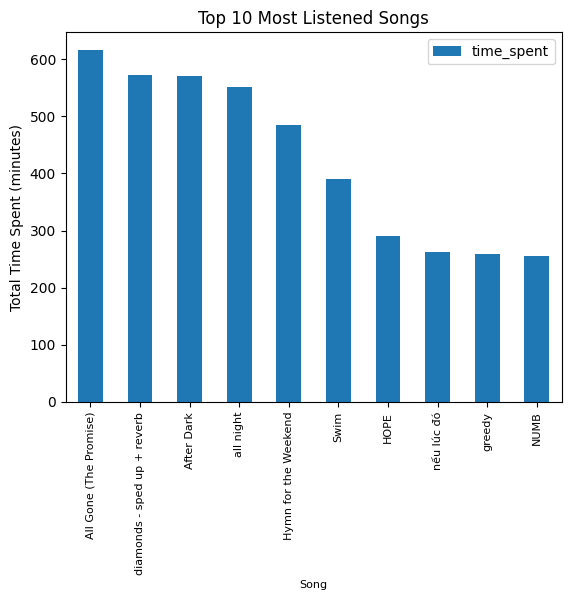

In [13]:
# Filter the data to only include the top tracks
# TOP_TRACKS_2023 = ['All Gone (The Promise)',
#                     'Show Me Love',
#                     'I Know - PR1SVX Edit',
#                     'After Dark',
#                     'Polozhenie']
# top_tracks_data_2023 = df[df['trackName'].isin(TOP_TRACKS_2023)]
# top_tracks_summary = top_tracks_data_2023.groupby('trackName')['time_spent'].sum().reset_index()

top_tracks_summary = df.groupby('trackName')['time_spent'].sum().reset_index()

top_tracks_summary = top_tracks_summary.sort_values('time_spent', ascending=False)

top_10_songs = top_tracks_summary.head(10)

# Plot the time spent on the top 10 songs
plt.figure(figsize=(12, 6))
ax = top_10_songs.plot(kind='bar', x='trackName', y='time_spent')
ax.set_xlabel('Song', fontsize=8)
plt.ylabel('Total Time Spent (minutes)')
plt.title('Top 10 Most Listened Songs')
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [14]:
print("Top 10 Most Listened Songs:")
for index, row in top_10_songs.iterrows():
    print(f"Song: {row['trackName']}, Total Time Spent: {row['time_spent']:.2f} minutes")

Top 10 Most Listened Songs:
Song: All Gone (The Promise), Total Time Spent: 616.51 minutes
Song: diamonds - sped up + reverb, Total Time Spent: 571.92 minutes
Song: After Dark, Total Time Spent: 570.66 minutes
Song: all night, Total Time Spent: 551.84 minutes
Song: Hymn for the Weekend, Total Time Spent: 485.02 minutes
Song: Swim, Total Time Spent: 391.09 minutes
Song: HOPE, Total Time Spent: 290.35 minutes
Song: nếu lúc đó, Total Time Spent: 261.64 minutes
Song: greedy, Total Time Spent: 258.27 minutes
Song: NUMB, Total Time Spent: 255.15 minutes


# Specific Track Listening Time

In [19]:
song_name = 'Khong Con Ice'

total_time_spent = df[df['trackName'] == song_name]['time_spent'].sum()
print(f"You spent {total_time_spent:.2f} minutes listening to '{song_name}'.")

You spent 83.81 minutes listening to 'Khong Con Ice'.
